<a href="https://colab.research.google.com/github/Abdul7571/Com774-cw2/blob/main/Boosting_Ensemble_Software_Defect_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'software-defect:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3501009%2F6110692%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240318%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240318T053424Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8ea8f2343ff570e79f065816fa32537d1623e53e4cf9e372f92dbedf12bbcb8ea50a357bd27e5bc2b5a2ea2ef39f0c2dba4f000141d6c698dd618aa2cf0e80d346c024a528183f3e5598f8ebf8c722400cf0263419765e8607283c47cd1075cab17aa93d3c0dc1504b5257a209722e415ae9c2e42823f2aee830bd6a107107b5a77dcdc004cf387f68e000f416a65c4d2b367c6532e01ba99f8d1f30eec29ba4a08137b061bb2be258838318113e37a6b704944e930b5fa16bb279accf5a5f0bc4c3e372300053ceb08027e83345281ea5bd27aa7ff3b66ce699585978a08fb55b88fb0222a6ceb25f49232938acfdf1a4bca9031dd75f6b616c35b0f28d26a1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 315165 bytes downloaded
Downloaded and uncompressed: software-defect
Data source import complete.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
#from keras.wrappers.scikit_learn import KerasClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/software-defect/jm1.csv
/kaggle/input/software-defect/cm1.csv


**Load the datasets**

In [4]:
data= pd.read_csv('/kaggle/input/software-defect/jm1.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10885 entries, 0 to 10884
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 10885 non-null  int64  
 1   loc                10885 non-null  float64
 2   v(g)               10885 non-null  float64
 3   ev(g)              10885 non-null  float64
 4   iv(g)              10885 non-null  float64
 5   n                  10885 non-null  float64
 6   v                  10885 non-null  float64
 7   l                  10885 non-null  float64
 8   d                  10885 non-null  float64
 9   i                  10885 non-null  float64
 10  e                  10885 non-null  float64
 11  b                  10885 non-null  float64
 12  t                  10885 non-null  float64
 13  lOCode             10885 non-null  int64  
 14  lOComment          10885 non-null  int64  
 15  lOBlank            10885 non-null  int64  
 16  locCodeAndComment  108

In [6]:
data.corr()["defects"]

<ipython-input-6-e66cda1ad3b4>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()["defects"]


id                  -0.684045
loc                  0.245388
v(g)                 0.208644
ev(g)                0.172973
iv(g)                0.181984
n                    0.204143
v                    0.189136
l                   -0.164917
d                    0.169629
i                    0.192831
e                    0.086036
b                    0.189342
t                    0.086036
lOCode               0.195897
lOComment            0.160887
lOBlank              0.199644
locCodeAndComment    0.117891
defects              1.000000
Name: defects, dtype: float64

**Data imbalance graph**

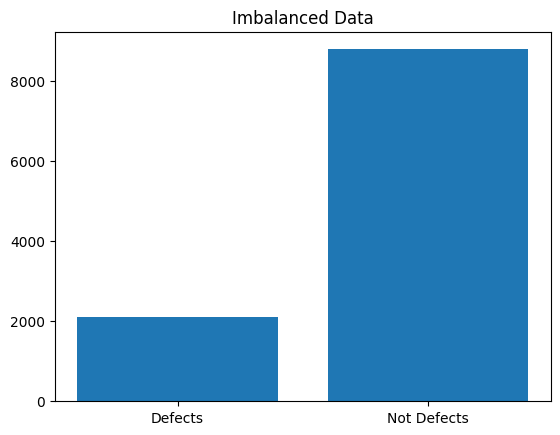

In [7]:
# data imbalance graph
defect_count = data[data["defects"] == True].shape[0]
not_defect_count = data[data["defects"] == False].shape[0]

data_counts = [defect_count, not_defect_count]
labels = ["Defects", "Not Defects"]

plt.bar(labels, data_counts)
plt.title("Imbalanced Data")
plt.show()

**Drop irrelevant columns (e.g., 'id') and columns with high cardinality (e.g., 'uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd')**

In [8]:
drop_columns = ['id', 'uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount']
data = data.drop(drop_columns, axis=1)

**Convert the 'defects' column to int type**

In [9]:


data['defects']= data['defects'].astype(int)

In [30]:
from sklearn.preprocessing import LabelEncoder

# Encode the 'defects' column to numerical values
label_encoder = LabelEncoder()
data['defects'] = label_encoder.fit_transform(data['defects'])

**Separate features and target**

In [31]:
X = data.drop('defects', axis=1).values
y = data['defects'].values

**Split the data into training and testing sets**

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Normalize the features using StandardScaler**

In [33]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


**Define the base model using a deep learning architecture**

In [34]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [35]:
# Create an instance of the base model
base_model = DecisionTreeClassifier(random_state=42)

In [36]:
# Create an instance of the AdaBoost classifier
boosting_model = AdaBoostClassifier(base_estimator=base_model, n_estimators=10, random_state=42, algorithm='SAMME')


**Train the AdaBoost Ensemble model**

In [37]:
# Train the AdaBoost ensemble model
boosting_model.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(random_state=42),
                   n_estimators=10, random_state=42)

In [38]:
# Make predictions using the AdaBoost ensemble model
y_pred = boosting_model.predict(X_test)

**Evaluate the model**

In [39]:
# Evaluate the performance of the AdaBoost ensemble model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
# Generate the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)


Accuracy: 77.91%
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.87      1758
           1       0.40      0.31      0.35       419

    accuracy                           0.78      2177
   macro avg       0.62      0.60      0.61      2177
weighted avg       0.76      0.78      0.77      2177



In [40]:
# Print the actual vs predicted values
df_actual_vs_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df_actual_vs_pred)

      Actual  Predicted
0          0          0
1          0          0
2          0          0
3          0          0
4          0          0
...      ...        ...
2172       0          0
2173       1          1
2174       0          0
2175       0          1
2176       0          0

[2177 rows x 2 columns]


In [20]:
!pip install shap
!pip install lime
!pip install lime.lime_tabular

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=c35d406148b58f50d6283ee3a5509a06888a0afaa96b2878ef41749bb5908e6a
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
ERROR: Could not find a version that satisfies the requirement lime.lime_tabular (from versions: none)
ERROR: No matching distribution found for lime.lime_tabular


In [25]:
import shap

# Apply SHAP
# Create a SHAP explainer object
shap_explainer = shap.Explainer(boosting_model.predict, X_train)

# Calculate SHAP values for the test set
shap_values = shap_explainer(X_test)

PermutationExplainer explainer: 2178it [03:39,  9.68it/s]


In [41]:
target_names = label_encoder.classes_.tolist()
print(target_names)

[0, 1]


In [42]:
feature_names = data.columns.tolist()[:-1]
print(feature_names)

['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't', 'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment']


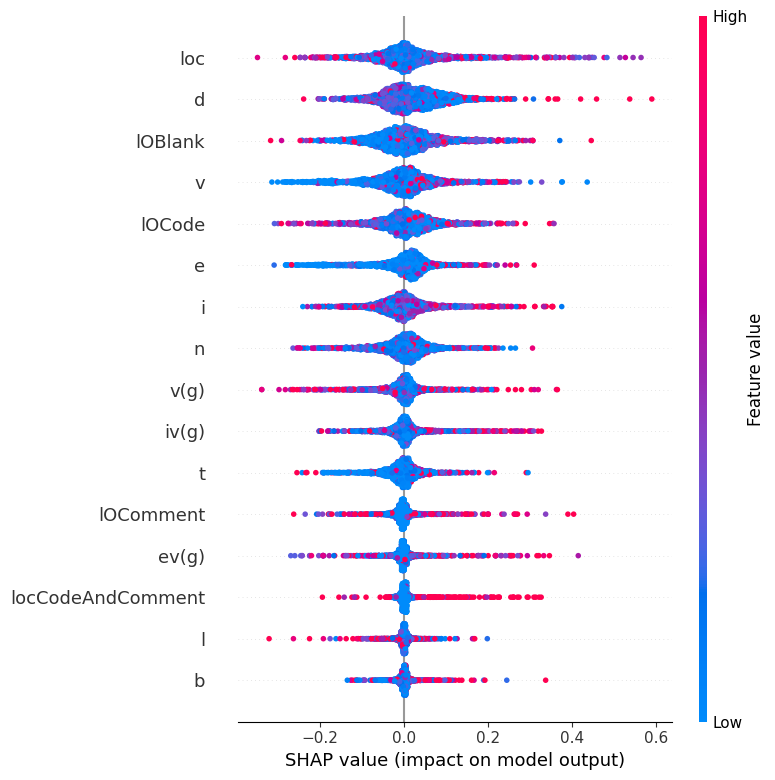

In [44]:
# Visualize the SHAP values - summary plot
shap.summary_plot(shap_values, X_test, feature_names=feature_names)



In [45]:
import lime
# Apply LIME
# Create a LIME explainer object
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names,
    class_names=target_names,
    mode='classification'
)

In [48]:
# Pick an instance to explain
instance_index = 1
instance = X_test[instance_index]

# Generate LIME explanation for this instance
lime_exp = lime_explainer.explain_instance(
    instance,
    boosting_model.predict_proba,  # Probability prediction function of the model
    num_features=len(feature_names),
    top_labels=1
)

# Visualize the LIME explanation
lime_exp.show_in_notebook(show_table=True, show_all=False)